# Data Visualization and Statistics
Examines the raw training and test data, as well as new data pulled from external sources

In [26]:
# All imports
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import utils
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# Raw training and test data

In [27]:
# Load raw data
raw_train_df = pd.read_csv(utils.RAW_TRAIN_PATH, dtype={"accession": str, "score": float})
raw_test_df = pd.read_csv(utils.RAW_TEST_PATH, dtype={"accession": str, "score": float})

In [ ]:
# # load top 10 most populated scoresets

# Filter only top scoresets
top_sets = raw_train_df["scoreset"].value_counts().head(10).index
subset = raw_train_df[raw_train_df["scoreset"].isin(top_sets)].dropna(subset=["score"])

In [ ]:
# # --- Raw score distributions (shape + scale differ by assay) ---

plt.figure(figsize=(10,6))
sns.histplot(
    data=subset,
    x="score",
    hue="scoreset",
    bins=40,
    element="step",     # outlines instead of filled bars
    stat="density",     # equivalent to density=True
    common_norm=False,  # don’t normalize across groups
    alpha=0.7
)

plt.xlabel("score")
plt.ylabel("density")
plt.title("Score distributions (top scoresets)")
plt.legend(fontsize=6, title="scoreset")
plt.tight_layout()
plt.show()

In [ ]:
# # --- Standardized (z-scored) per scoreset: compare shapes only ---

# Keep only the top scoresets and non-NaN scores
subset = raw_train_df[raw_train_df["scoreset"].isin(top_sets)].dropna(subset=["score"]).copy()

# Per-scoreset stats with population std (ddof=0) to match your code exactly
stats = (
    subset.groupby("scoreset")["score"]
          .agg(mean=lambda s: np.mean(s),
               std=lambda s: np.std(s, ddof=0),
               count="size")
          .reset_index()
)

# Filter out groups with <5 samples or zero variance
good = stats[(stats["count"] >= 5) & (stats["std"] > 0)]

# Merge back and compute z-scores within each scoreset
subset = subset.merge(good[["scoreset", "mean", "std"]], on="scoreset", how="inner")
subset["z"] = (subset["score"] - subset["mean"]) / subset["std"]

# Plot: overlaid step histograms (density per group)
plt.figure(figsize=(10, 6))
sns.histplot(
    data=subset,
    x="z",
    hue="scoreset",
    bins=40,
    stat="density",       # like density=True
    common_norm=False,    # normalize each scoreset separately
    element="step",       # step outline (like histtype='step')
    fill=False,
    multiple="layer",
    alpha=0.8
)
plt.xlabel("z-score within scoreset")
plt.ylabel("density")
plt.title("Standardized distributions (top scoresets)")
plt.legend(fontsize=6, title="scoreset")
plt.tight_layout()
plt.show()

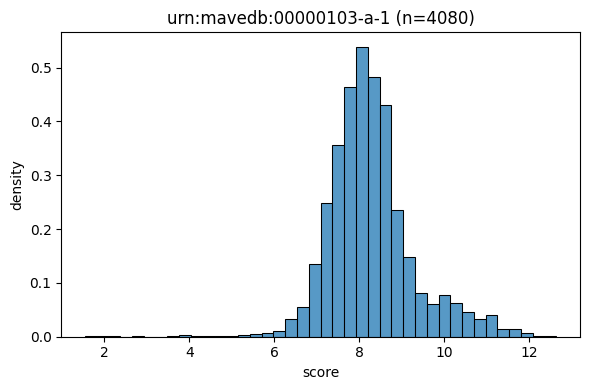

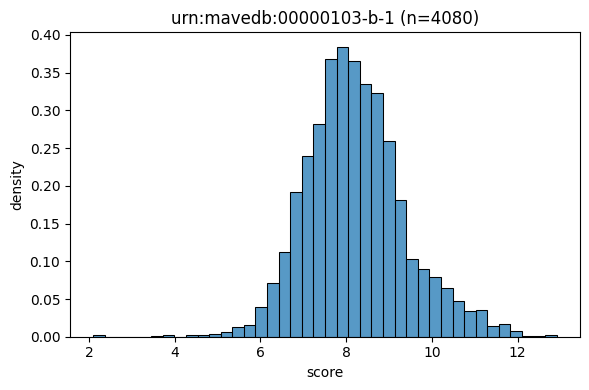

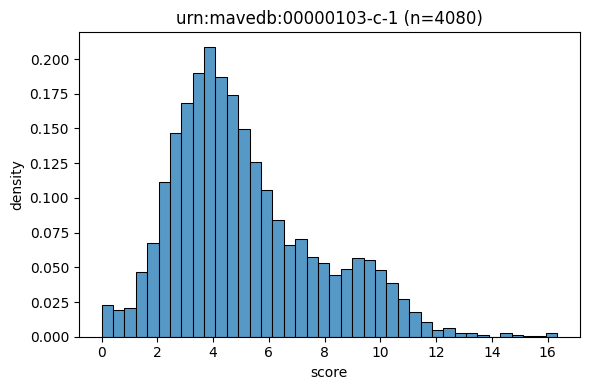

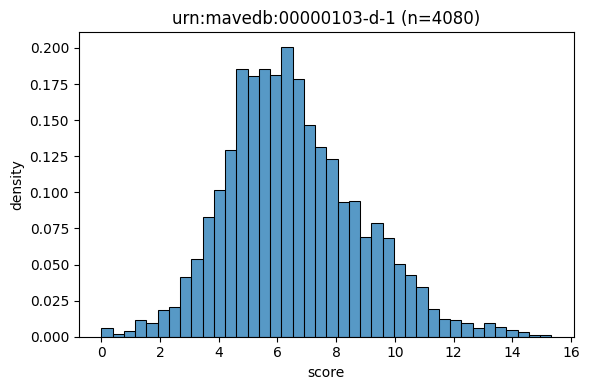

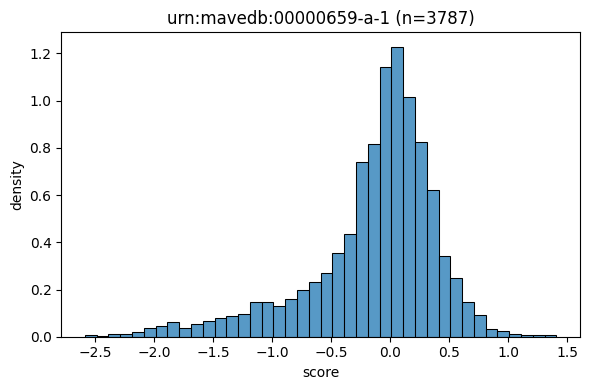

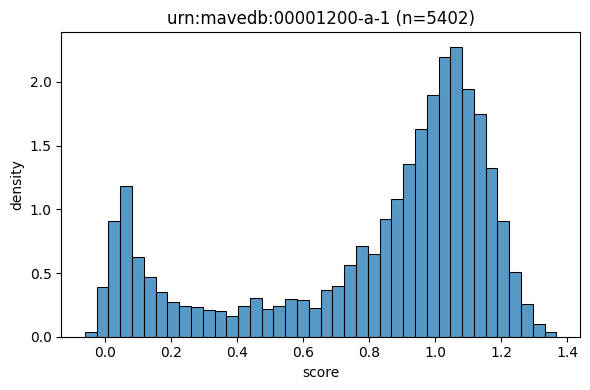

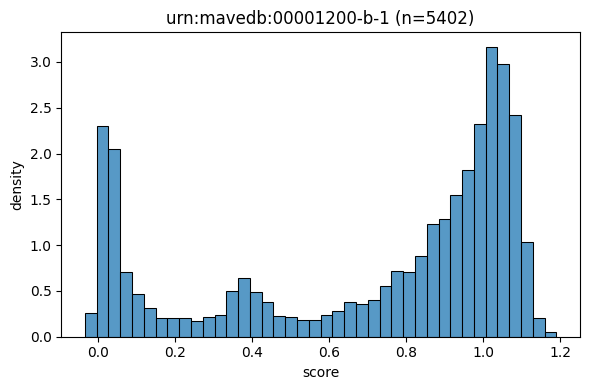

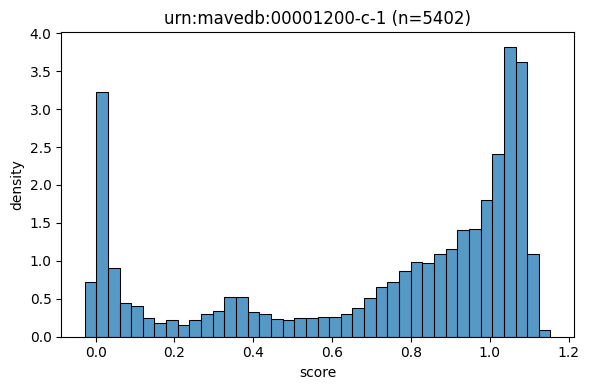

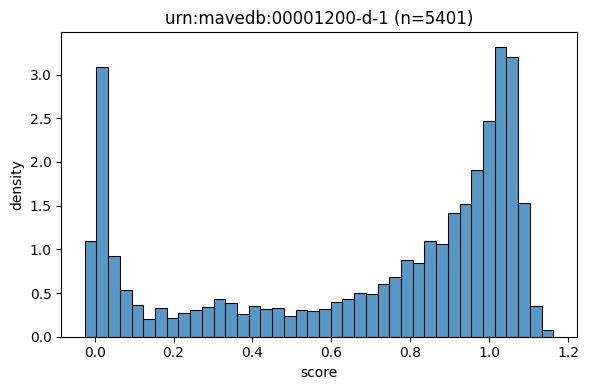

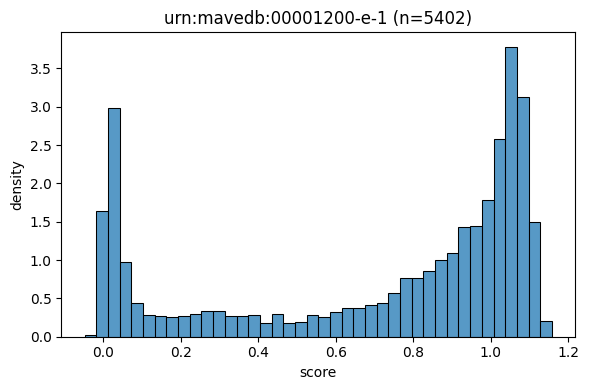

In [ ]:
# Display scoresets seperately
import re

# assume: raw_train_df, top_sets defined
subset = (
    raw_train_df[raw_train_df["scoreset"].isin(top_sets)]
    .dropna(subset=["score"])
)

def safe_name(s: str) -> str:
    return re.sub(r'[\\/:*?"<>|#]+', "_", str(s)).strip("_")

# one figure per scoreset
for s, grp in subset.groupby("scoreset"):
    if len(grp) < 5:
        continue
    plt.figure(figsize=(6,4))
    sns.histplot(data=grp, x="score", bins=40, stat="density")
    plt.xlabel("score"); plt.ylabel("density")
    plt.title(f"{s} (n={len(grp)})")
    plt.tight_layout()
    # Optional save:
    # out = Path("figs"); out.mkdir(exist_ok=True, parents=True)
    # plt.savefig(out / f"dist_{safe_name(s)}.png", dpi=200)
    plt.show()


In [ ]:
# heatmap
pivot = raw_train_df[raw_train_df.alt_short!="*"].pivot_table(index="ref_short", columns="alt_short", values="score", aggfunc="median")
sns.heatmap(pivot.loc[sorted(pivot.index), sorted(pivot.columns)], cmap="vlag", center=0)

In [ ]:
# --- Quantify how much score varience is affected by scoreset, ref_short, and alt_short

df = raw_train_df.dropna(subset=["score","scoreset","ref_short","alt_short"]).copy()
model = smf.ols("score ~ C(scoreset) + C(ref_short) + C(alt_short) + C(ref_short):C(alt_short)", data=df).fit()
anova = sm.stats.anova_lm(model, typ=2)  # sums of squares per factor
print(anova)

# 69% of the variance in score comes directly from the scoreset
print("---------- % variance that is explained by this factor ----------")
total = anova["sum_sq"].sum()
(anova["sum_sq"] / total) * 100

c:\Users\brady\Documents\Digital Textbooks\MLM_2025\mlm25_mavedb\.venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 9
  warnings.warn('covariance of constraints does not have full '
c:\Users\brady\Documents\Digital Textbooks\MLM_2025\mlm25_mavedb\.venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 10
  warnings.warn('covariance of constraints does not have full '
c:\Users\brady\Documents\Digital Textbooks\MLM_2025\mlm25_mavedb\.venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 360, but rank is 342
  warnings.warn('covariance of constraints does not have full '
c:\Users\brady\Documents\Digital Textbooks\MLM_2025\mlm25_mavedb\.venv\Lib\site-packages\statsmodels\base

                          C(ref_short)  C(alt_short)  \
urn:mavedb:00001005-a-1       3.181119     55.891040   
urn:mavedb:00000115-a-24   -101.094078     55.638030   
urn:mavedb:00000811-a-1       2.428656     53.971290   
urn:mavedb:00001127-a-1       2.760824     49.140773   
urn:mavedb:00001191-a-1       8.810495     46.473019   
urn:mavedb:00001179-a-1       2.867439     42.864208   
urn:mavedb:00000935-a-1      13.333831     42.635041   
urn:mavedb:00001177-a-1      16.686656     40.525044   
urn:mavedb:00001033-a-1      22.350277     38.905356   
urn:mavedb:00001159-a-1      19.422546     37.013079   

                          C(ref_short):C(alt_short)   Residual error  
urn:mavedb:00001005-a-1                   40.556376   0.371466     0  
urn:mavedb:00000115-a-24                 118.758796  26.697253     0  
urn:mavedb:00000811-a-1                   36.601093   6.998960     0  
urn:mavedb:00001127-a-1                   41.145999   6.952404     0  
urn:mavedb:00001191-a-1     

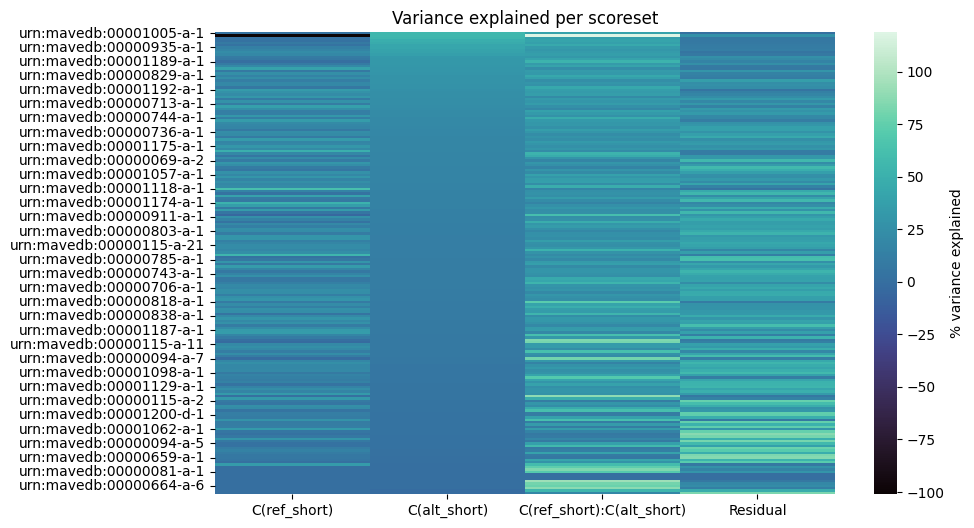

In [29]:
# --- Measures how significant ref_short and alt_short impact score within a scoreset ---

# “When we look inside each experiment, we see that the identity of the new amino acid (Alt) usually explains 
# more than the original amino acid (Ref). The specific substitution (Ref→Alt) sometimes matters a lot, but in 
# many assays most of the variance remains unexplained. This shows that experiment context (scoreset) and extra
#  biological features will be essential for improving predictions.”

# Keep only valid rows
df = raw_train_df.dropna(subset=["score", "scoreset", "ref_short", "alt_short"])

# Function: run ANOVA for one scoreset
def per_scoreset_anova(subset):
    try:
        model = smf.ols("score ~ C(ref_short) + C(alt_short) + C(ref_short):C(alt_short)", data=subset).fit()
        anova = anova_lm(model, typ=2)
        
        # Total variance explained = sum of squares
        total_ss = anova["sum_sq"].sum()
        results = {factor: anova.loc[factor, "sum_sq"] / total_ss * 100 for factor in anova.index}
        return results
    except Exception as e:
        return {"error": str(e)}

# Loop over scoresets
results = {}
for s, subset in df.groupby("scoreset"):
    if len(subset) < 50:   # skip tiny groups
        continue
    results[s] = per_scoreset_anova(subset)

# Convert to dataframe
res_df = pd.DataFrame(results).T.fillna(0)

# Sort by how much "alt_short" matters
res_df = res_df.sort_values("C(alt_short)", ascending=False)

print(res_df.head(10))

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(res_df[["C(ref_short)", "C(alt_short)", "C(ref_short):C(alt_short)", "Residual"]],
            cmap="mako", annot=False, cbar_kws={'label': '% variance explained'})
plt.title("Variance explained per scoreset")
plt.show()
